In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Sampler,Estimator
import pickle 
import time
from qiskit.circuit.library import iSwapGate


In [179]:
J=1e0

nQ=3
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

In [180]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    

In [181]:
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    center_index=np.ceil((n_qubits-1)/2)
    
    #First produce the initial state:
    for i in range(n_qubits):
   
        #for some reason need x everything first
        if i!=center_index:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        for i in range(int(n_qubits/3)):
            tmpIndex=i*3
            add3Q(circuit,tmpIndex,alpha=J)
        circuit.barrier()
        
            
        for i in range(int(n_qubits/3)):
            tmpIndex=i*3+2
            add3Q(circuit,tmpIndex,alpha=J)
    
        circuit.barrier()
        
        for i in range(int(n_qubits/3)):
            tmpIndex=i*3
            circuit.rz(0,tmpIndex)
            circuit.rx(f,tmpIndex+1)
            circuit.rz(0,tmpIndex+2)
            
#     for i in range(n_qubits):
#         if i%2==0:
#             continue
#         circuit.h(i)
#    circuit.measure(circuit.qubits,circuit.clbits)
    return circuit
    
    
    

In [182]:

# circuit = getTrotterCircuit(n_qubits,J,nTrotter=0)
# circuit.draw('mpl')
# sampler=Sampler()
# job=sampler.run([circuit])
# a=job.result().quasi_dists[0]
# a.binary_probabilities()

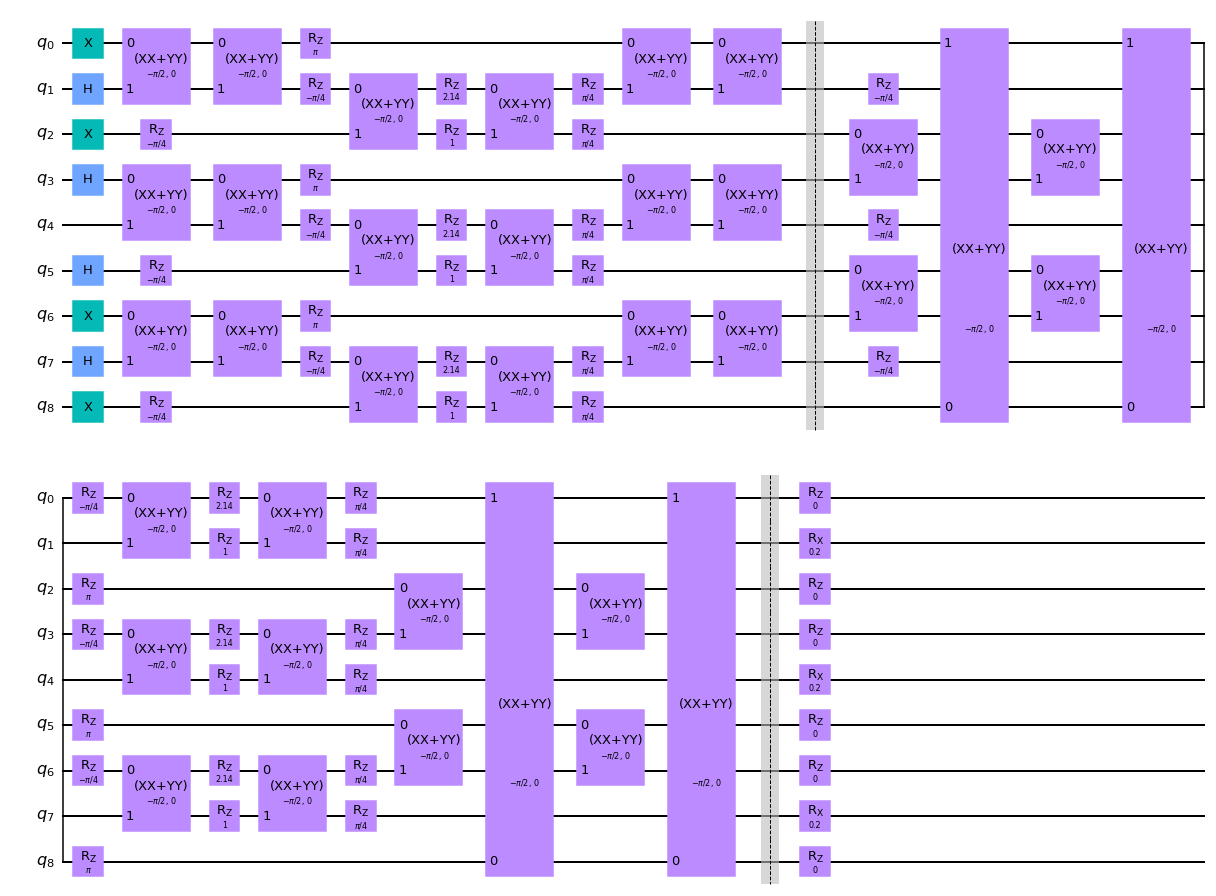

In [183]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1)
circuit.draw('mpl')

In [184]:
observable_list=[]
for i in range(n_qubits):
    if i%2!=0:
        observable=SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-i-1) , 1)])
        observable_list.append(observable)
        
    else:
  
        observable=SparsePauliOp.from_list([("I"*(i)+"Z"+"I"*(n_qubits-i-1) , -1)])
        observable_list.append(observable)
print(observable_list)


[SparsePauliOp(['ZIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IXIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIXIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIXIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIXI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZ'],
              coeffs=[-1.+0.j])]


In [186]:
estimator=Estimator()
results_list_2=[]
nSteps=50
for i in range(nSteps):
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=2,dtFactor=0.2)

    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2.append(results)
    print(i," steps results = ",results)
    
results_list_2=np.array(results_list_2)

0  steps results =  [ 1.  1.  1.  1. -1.  1.  1.  1.  1.]
1  steps results =  [ 0.29192658  0.54030231  1.          0.29192658 -0.17317819 -0.2248451
 -0.41614684  0.54030231  1.        ]
2  steps results =  [-0.04226565  0.11252787  0.49863203 -0.06956747 -0.50309048  0.16637553
 -0.08179537 -0.00123427 -0.00273593]
3  steps results =  [-2.32492199e-01  2.70355725e-01  2.67561953e-01 -2.37028980e-04
  7.16368075e-02  5.31045605e-03 -5.64803288e-01  1.55063553e-01
  1.44042926e-01]
4  steps results =  [ 0.06537829  0.03760519  0.06585941  0.20895123  0.05605528 -0.02145734
 -0.09347476  0.10184675 -0.13561444]
5  steps results =  [-0.04763049  0.26057066  0.28037543  0.1376226   0.1429526   0.10786404
 -0.10491219  0.1982554   0.17603838]
6  steps results =  [-0.04398104  0.24787373  0.11380363  0.17744042  0.00598983  0.06594836
  0.2416528   0.20213456 -0.06973504]
7  steps results =  [ 0.13945167  0.19400122 -0.003406   -0.05961924 -0.12703082  0.09262779
  0.15552867  0.29104603  0

<Figure size 432x288 with 0 Axes>

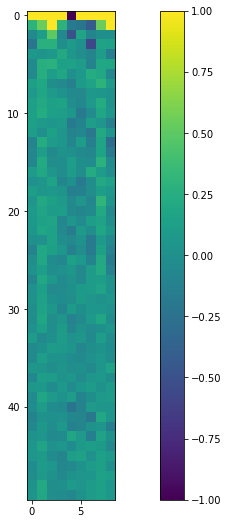

In [187]:

plt.figure(1)
plt.figure(figsize=(16,9))
plt.imshow(results_list_2, interpolation='none')
plt.colorbar()
plt.show()

In [188]:
estimator=Estimator()
results_list_2en2=[]
nSteps=40
for i in range(nSteps):
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=0.2,dtFactor=0.2)

    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2en2.append(results)
    print(i," steps results = ",results)
    
results_list_2en2=np.array(results_list_2en2)

0  steps results =  [ 1.  1.  1.  1. -1.  1.  1.  1.  1.]
1  steps results =  [ 0.29192658  0.54030231  1.          0.29192658  0.40785161 -0.2248451
 -0.41614684  0.54030231  1.        ]
2  steps results =  [ 5.01817120e-01  1.64504356e-02  4.98632034e-01 -4.52637416e-03
  9.43045035e-01  9.02443498e-02  1.77485654e-02  2.27140072e-04
 -2.73593133e-03]
3  steps results =  [ 0.93572043  0.06280758  0.06220168  0.05079628  0.91828383 -0.12549131
  0.87876167 -0.10622235 -0.86630815]
4  steps results =  [ 0.84131403  0.74069432  0.84863071  0.74657111 -0.45211266  0.38109433
  0.67315857  0.55740967  0.70687641]
5  steps results =  [ 0.78144914  0.7034946   0.97042311  0.6477455  -0.51755516  0.47272721
  0.54999104  0.76346099  0.9106594 ]
6  steps results =  [ 0.14072758  0.15961195  0.89228579  0.04502514  0.7988836  -0.17487845
 -0.68515853  0.19147323  0.76443625]
7  steps results =  [ 0.82047836  0.18491457  0.14331776 -0.04760911  0.82192748  0.120989
  0.70602036  0.14846817 -0.7

<Figure size 432x288 with 0 Axes>

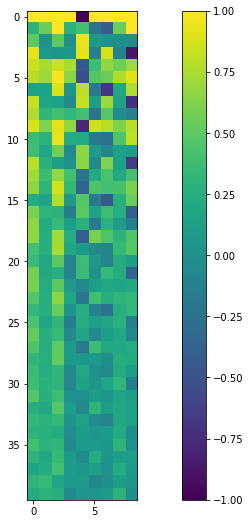

In [189]:

plt.figure(1)
plt.figure(figsize=(16,9))
plt.imshow(results_list_2en2, interpolation='none')
plt.colorbar()
plt.show()